In [42]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import (accuracy_score,
                             confusion_matrix,
                             roc_curve, auc, roc_auc_score, recall_score, precision_score)

In [59]:
current_directory = Path.cwd()
DATA_PATH = current_directory.parent / 'data/train.csv'

### 1. Получите и загрузите данные.

In [60]:
data = pd.read_csv(DATA_PATH)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [61]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [63]:
data.duplicated().sum()

0

In [64]:
data.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [65]:
def missing_values(data):
    na_columns = [column for column in data.columns if data[column].isnull().sum() > 0]
    n_miss = data[na_columns].isnull().sum().sort_values(ascending=False)
    ratio = (data[na_columns].isnull().sum() / data.shape[0] * 100).sort_values(ascending=False)
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    if len(missing_df) > 0:
        print(missing_df, end="\n")
    else:
        print("No NaN values")

In [66]:
missing_values(data)

          n_miss  ratio
Cabin        687  77.10
Age          177  19.87
Embarked       2   0.22


### 2. Удалите все пропущенные значения и категориальные переменные. Обучите модель. Выберете и посчитайте метрику качества.

In [67]:
def remove_categorical_columns(data):
    categorical_columns = data.select_dtypes(include=['object']).columns
    data.drop(categorical_columns, axis=1, inplace=True)
    return data

In [68]:
without_cat_data = remove_categorical_columns(data)

In [69]:
clean_data = without_cat_data.dropna(axis=1)
clean_data = clean_data.dropna(axis=0)

In [70]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   SibSp        891 non-null    int64  
 4   Parch        891 non-null    int64  
 5   Fare         891 non-null    float64
dtypes: float64(1), int64(5)
memory usage: 41.9 KB


In [71]:
X = clean_data.drop(columns=['Survived'])
y = clean_data['Survived']

In [72]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [73]:
lr = LogisticRegression()
lr.fit(X_train, y_train)
train_pred = lr.predict(X_train)
test_pred = lr.predict(X_test)

In [74]:
print('TRAIN DATA')
print(100 * accuracy_score(y_train, train_pred))
print(100 * precision_score(y_train, train_pred))
print(100 * recall_score(y_train, train_pred))
print(100 * roc_auc_score(y_train, train_pred))

print('TEST DATA')
print(100 * accuracy_score(y_test, test_pred))
print(100 * precision_score(y_test, test_pred))
print(100 * recall_score(y_test, test_pred))
print(100 * roc_auc_score(y_test, test_pred))

TRAIN DATA
67.83707865168539
60.773480662983424
41.04477611940299
62.526892564205994
TEST DATA
71.50837988826815
70.17543859649122
54.054054054054056
68.93178893178893


### 3. Снова загрузите полные данные

In [96]:
current_directory = Path.cwd()
DATA_PATH = current_directory.parent / 'data/train.csv'
data = pd.read_csv(DATA_PATH)
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### 4. Удалите признаки, которые логически не нужны для построения модели. Обоснуйте.

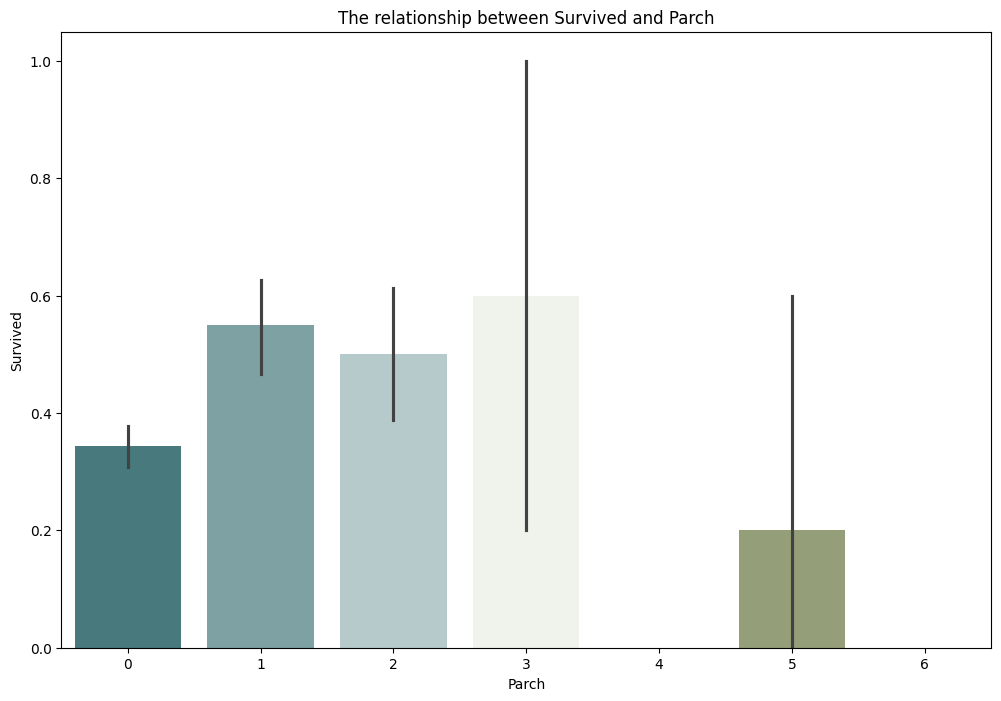

In [97]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Parch', y='Survived', hue='Parch', legend=False, data=data, palette=cmap)
plt.title('The relationship between Survived and Parch')
plt.xlabel('Parch')
plt.ylabel('Survived')
plt.show()

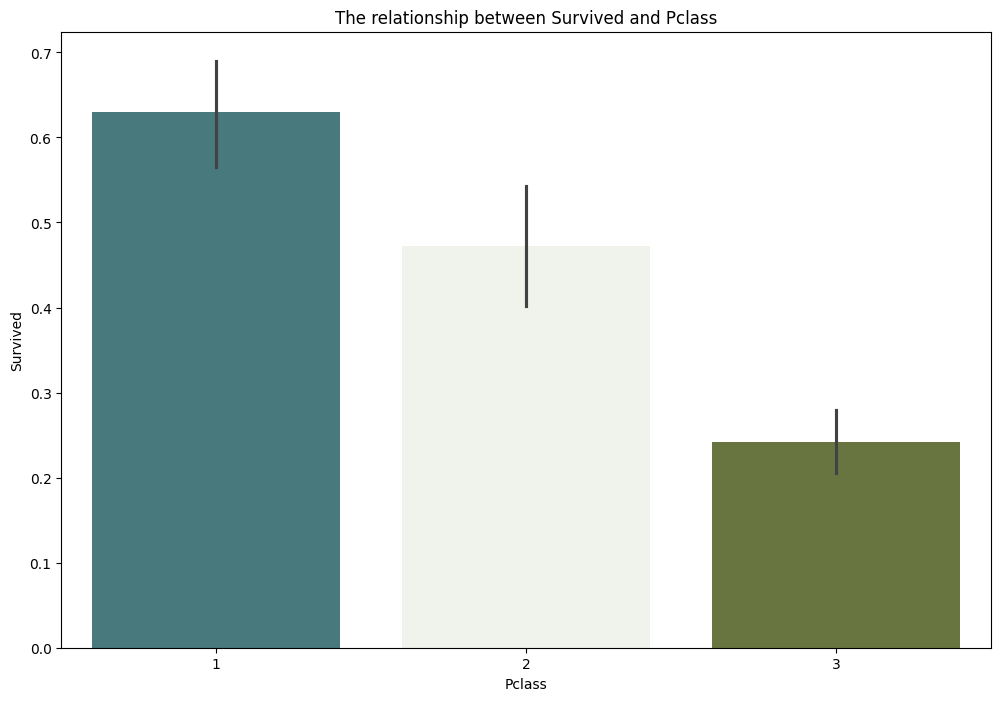

In [98]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Pclass', y='Survived', hue='Pclass', legend=False, data=data, palette=cmap)
plt.title('The relationship between Survived and Pclass')
plt.xlabel('Pclass')
plt.ylabel('Survived')
plt.show()

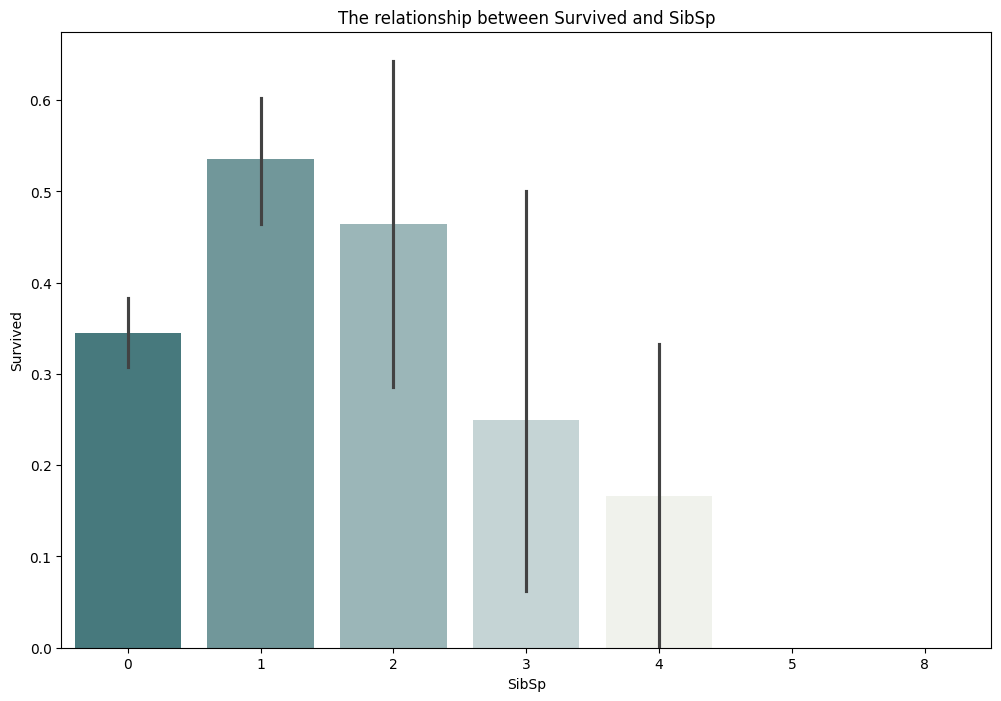

In [99]:
plt.figure(figsize=(12, 8))
sns.barplot(x='SibSp', y='Survived', hue='SibSp', legend=False, data=data, palette=cmap)
plt.title('The relationship between Survived and SibSp')
plt.xlabel('SibSp')
plt.ylabel('Survived')
plt.show()

In [159]:
clean_data = data.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])

- Имя человека аналогичным образом не может тебя спасти от смерти
- Номер кабины мог бы повлиять на то, выживешь ты или нет. Например, если кабины находится у самого выхода, но с учётом того, что 70% данных в этом признаке отсутсвует - он становится бесполезен, даже если попробовать заполнить модой
- Номер билета не может повлиять на шанс твоей выживаемости
- PassengerId - просто индекс от которого можно избавиться

### 5. Проверьте данные на наличие пропущенных значений.
- Посчитайте, какой процент данных будет потерян, если просто удалить пропуски.
- Заполните пропуски: средним значением; константой; классом, указывающим на то, что значение было пропущено; случайным числом. Для разных признаков используйте подходящий метод. Можно не использовать все перечисленные методы.

In [160]:
clean_data.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


In [161]:
calculate_perc_data = clean_data.dropna(axis=0)
percentage_lost = 100 - (calculate_perc_data.shape[0] / clean_data.shape[0]) * 100
print("Процент данных, которые будут потеряны при удалении пропусков: {:.2f}%".format(percentage_lost))

Процент данных, которые будут потеряны при удалении пропусков: 20.09%


In [162]:
clean_data.isna().sum()

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Embarked      2
dtype: int64

In [163]:
clean_data['Embarked'] = clean_data['Embarked'].fillna('Unknown')
clean_data['Age'] = clean_data['Age'].fillna(clean_data['Age'].mean())

In [164]:
clean_data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.000000,1,0,7.2500,S
1,1,1,female,38.000000,1,0,71.2833,C
2,1,3,female,26.000000,0,0,7.9250,S
3,1,1,female,35.000000,1,0,53.1000,S
4,0,3,male,35.000000,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,male,27.000000,0,0,13.0000,S
887,1,1,female,19.000000,0,0,30.0000,S
888,0,3,female,29.699118,1,2,23.4500,S
889,1,1,male,26.000000,0,0,30.0000,C


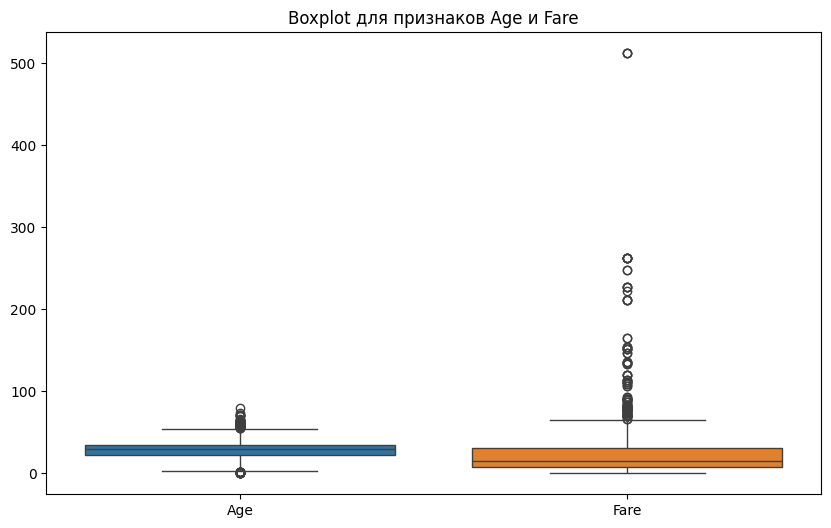

In [165]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=clean_data[['Age', 'Fare']])
plt.title("Boxplot для признаков Age и Fare")
plt.show()

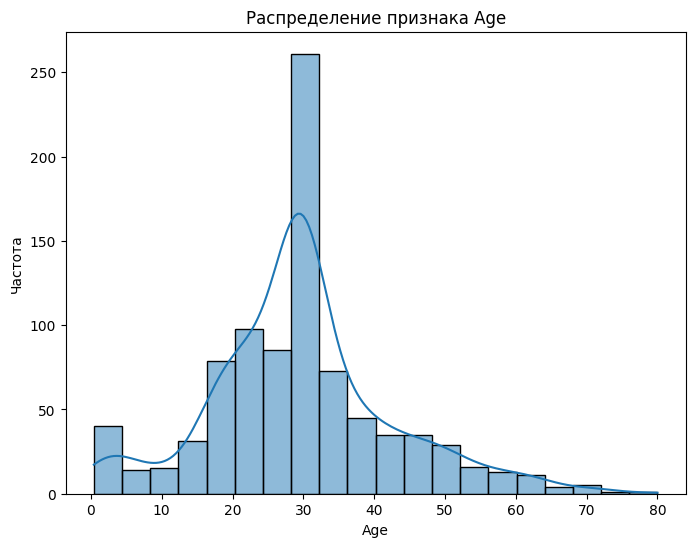

In [166]:
plt.figure(figsize=(8, 6))
sns.histplot(clean_data['Age'], bins=20, kde=True)
plt.title("Распределение признака Age")
plt.xlabel("Age")
plt.ylabel("Частота")
plt.show()

### 6.Категориальные переменные переведите в цифровые значения. Можно использовать pd.get_dummies, preprocessing.LabelEncoder. Старайтесь не использовать для этой задачи циклы.

In [167]:
clean_data = pd.get_dummies(clean_data, columns=['Sex', 'Embarked'], drop_first=True)

### 7. Проверьте данные на наличие выбросов.
- Удалите выбросы, если считаете это целесообразным. Обоснуйте.

In [168]:
clean_data = clean_data[clean_data['Fare'] < 200]
clean_data

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Embarked_Unknown
0,0,3,22.000000,1,0,7.2500,True,False,True,False
1,1,1,38.000000,1,0,71.2833,False,False,False,False
2,1,3,26.000000,0,0,7.9250,False,False,True,False
3,1,1,35.000000,1,0,53.1000,False,False,True,False
4,0,3,35.000000,0,0,8.0500,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...
886,0,2,27.000000,0,0,13.0000,True,False,True,False
887,1,1,19.000000,0,0,30.0000,False,False,True,False
888,0,3,29.699118,1,2,23.4500,False,False,True,False
889,1,1,26.000000,0,0,30.0000,True,False,False,False


### 8. *Постройте 1-2 графика на выбор. Визуализация должна быть основана на исследуемых данных и быть полезной (из графика можно сделать вывод об особенностях датасета/класса/признака)

In [169]:
# Визуализацией занимался выше в ноутбуке.

### 9. *Попробуйте математически преобразовать признак Age.

In [ ]:
clean_data['Age'] = np.log(clean_data['Age'])

### 10. Обучите ту же модель, что в п. 2 на преобразованных данных. Посчитайте ту же, что в п. 2 метрику.

In [172]:
X = clean_data.drop(columns=['Survived'])
y = clean_data['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

sc = StandardScaler()
X_train[['Age', 'Fare']] = sc.fit_transform(X_train[['Age', 'Fare']])
X_test[['Age', 'Fare']] = sc.transform(X_test[['Age', 'Fare']])
lr = LogisticRegression()
lr.fit(X_train, y_train)
train_pred = lr.predict(X_train)
test_pred = lr.predict(X_test)

In [173]:
print('TRAIN DATA')
print(100 * accuracy_score(y_train, train_pred))
print(100 * precision_score(y_train, train_pred))
print(100 * recall_score(y_train, train_pred))
print(100 * roc_auc_score(y_train, train_pred))

print('TEST DATA')
print(100 * accuracy_score(y_test, test_pred))
print(100 * precision_score(y_test, test_pred))
print(100 * recall_score(y_test, test_pred))
print(100 * roc_auc_score(y_test, test_pred))

TRAIN DATA
81.89655172413794
78.9237668161435
69.01960784313725
79.18100573562758
TEST DATA
76.57142857142857
72.85714285714285
69.86301369863014
75.617781359119


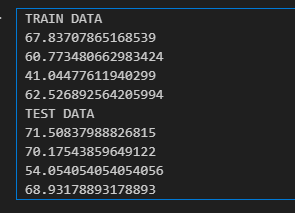

### 11. Сформулируйте выводы по проделанной работе.
- Кратко опишите какие преобразования были сделаны и почему.
- Сравните метрики моделей из п. 2 и п. 10.
- Напишите свое мнение о целесообразности работы с данными при построении моделей машинного обучения. *Нужно ли аналогичным образов исследовать и дополнять действительно большие данные?

- Нормализовали данные. Применили OHE для кат. признаков, избавились от выбросов в признаки Fare, а также почистили данные от NaN.
- После всех преобразований метрика AUC_SCORE увеличилась с 62% на трейн и 68% тестовой выборках до 79% и 75% соответственно.
- Это один из самых важных этапов в процессе построения ML моделей. Неправильная обработка данных может привести к неверным выводам и низкому качества модели, а понимание данных и их особенностей помогает выбрать наиболее подходящие методы и модели для решения той или иной задачи. Нужно, принципы остаются те же, просто необходимо подобрать специиальные подходы и техники для эффективной обработки и анализа данных.